# Pneumonia Detection

## Loading of the data and preprocessing

In [1]:
import cv2 as cv
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications.xception import preprocess_input
import numpy as np
import os
import random

def preprocessing(filepath, img_size=(299,299), n_channel=3):
    img = cv.imread(filepath)
    img = cv.resize(img, img_size, interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)   
    img = img/255
    img = np.reshape(img, (img_size[0],img_size[1],1))
    return img






def data_label_builder(normal_path, pneumonia_path,img_size=(299,299)):
    normal = [preprocessing(f'{normal_path}/{file}', img_size=img_size) for file in os.listdir(normal_path)]
    pneumonia = [preprocessing(f'{pneumonia_path}/{file}', img_size=img_size) for file in os.listdir(pneumonia_path)]
    normal_labels = np.tile(1, len(normal))
    pneumonia_labels = np.tile(0, len(pneumonia))
    X = np.concatenate([normal, pneumonia])
    #X = np.expand_dims(X, axis=-1)
    y = np.concatenate([normal_labels, pneumonia_labels])
    return X, y

In [2]:

#physical_devices = tf.config.list_physical_devices('CPU') 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
im_size = (150,150)

normal_train = 'chest_xray/train/NORMAL'
pneumonia_train = 'chest_xray/train/PNEUMONIA'

normal_test = 'chest_xray/test/NORMAL'
pneumonia_test = 'chest_xray/test/PNEUMONIA'


X_train, y_train = data_label_builder(normal_train, pneumonia_train, img_size=im_size)
X_test, y_test = data_label_builder(normal_test, pneumonia_test, img_size=im_size)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5216, 150, 150, 1), (5216,), (624, 150, 150, 1), (624,))

In [4]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

In [105]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = len(y_train)
pos = sum(y_train)
neg = total-pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 1.98


In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen_batch_size = 16

datagen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

train_generator = datagen.flow(X_train, y_train, batch_size=datagen_batch_size)
train_dataset = tf.data.Dataset.from_generator(lambda: map(tuple,train_generator),(tf.float32, tf.float32))



validation_generator = datagen.flow(X_val, y_val, batch_size=datagen_batch_size)
validation_dataset = tf.data.Dataset.from_generator(lambda: map(tuple,validation_generator),(tf.float32, tf.float32))


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def training_preparation(ds):
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_dataset = training_preparation(train_dataset)
validation_dataset = training_preparation(validation_dataset)

## Creation and training of the model

In [123]:
inputs = Input(shape=(150,150,1))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
conv1 = MaxPool2D(pool_size=(2, 2), strides = 2, padding='same')(x)

x = Conv2D(64, 3, activation='relu', padding='same')(conv1)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
conv2 = MaxPool2D(pool_size=(2, 2), strides = 2, padding='same')(x)

x = Conv2D(64, 3, activation='relu', padding='same')(conv2)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
conv3 = MaxPool2D(pool_size=(4, 4), strides = 4, padding='same')(x)

x = Conv2D(128, 3, activation='relu', padding='same')(conv3)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
conv4 = MaxPool2D(pool_size=(2, 2), strides = 2, padding='same')(x)



x = Flatten()(conv4)


x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
mariaunet = Model(inputs, outputs) 

# Summarize
mariaunet.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 75, 75, 64)        3692

In [124]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
mariaunet.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy',])

history = mariaunet.fit(train_generator, epochs=15, validation_data=validation_generator, 
                        callbacks = [learning_rate_reduction], class_weight=class_weight)

Epoch 1/15
261/261 [==============================] - 36s 134ms/step - loss: 0.5392 - accuracy: 0.7814 - val_loss: 5.9235 - val_accuracy: 0.7251
Epoch 2/15
261/261 [==============================] - 33s 125ms/step - loss: 0.3961 - accuracy: 0.8253 - val_loss: 1.8580 - val_accuracy: 0.7433
Epoch 3/15
261/261 [==============================] - 32s 123ms/step - loss: 0.3834 - accuracy: 0.8538 - val_loss: 0.9678 - val_accuracy: 0.7701
Epoch 4/15
261/261 [==============================] - 32s 123ms/step - loss: 0.3531 - accuracy: 0.8562 - val_loss: 0.4051 - val_accuracy: 0.8199
Epoch 5/15
261/261 [==============================] - 33s 125ms/step - loss: 0.3058 - accuracy: 0.8809 - val_loss: 0.3477 - val_accuracy: 0.8649
Epoch 6/15
261/261 [==============================] - 32s 123ms/step - loss: 0.2928 - accuracy: 0.8794 - val_loss: 0.2391 - val_accuracy: 0.8956
Epoch 7/15
261/261 [==============================] - 33s 126ms/step - loss: 0.3011 - accuracy: 0.8885 - val_loss: 0.8024 - val_ac

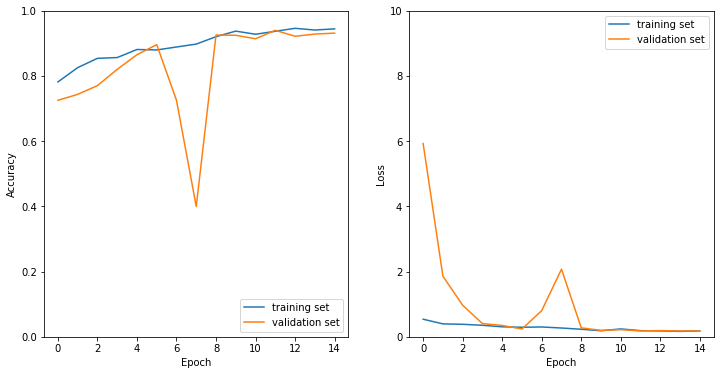

In [125]:
import matplotlib.pyplot as plt
def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='upper right')
    
plot_history(history)

In [117]:
#mariaunet.save('mariaunet')

INFO:tensorflow:Assets written to: mariaunet/assets


## Evaluation of the model

In [129]:
#mariaunet = tf.keras.models.load_model('mariaunet')

In [130]:
loss, acc = mariaunet.evaluate(X_test, y_test, verbose=2)


20/20 - 1s - loss: 0.3344 - accuracy: 0.9006


In [131]:
from sklearn.metrics import confusion_matrix


preds = mariaunet.predict(X_test, batch_size=16)
confusion_matrix(y_test, np.where(preds>0.5, 1,0))


array([[384,   6],
       [ 56, 178]])

In [132]:
confusion = confusion_matrix(y_test, np.where(preds>.5, 1,0))
pre = confusion[0][0]/(confusion[0][0]+confusion[1][0])
rec = confusion[0][0]/(confusion[0][0]+confusion[0][1])
print(f'Precision: {pre}, Recall: {rec}')

Precision: 0.8727272727272727, Recall: 0.9846153846153847


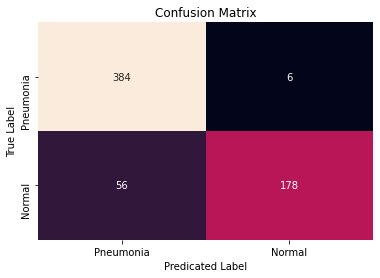

In [148]:
import seaborn as sns

categories = ['Pneumonia', 'Normal']
plt.title('Confusion Matrix')
sns.heatmap(confusion, annot=True, 
            cbar=False, xticklabels=categories, 
            yticklabels=categories,fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()  

In [162]:
test_img = preprocessing("chest_xray/test/PNEUMONIA/person22_virus_55.jpeg", img_size=im_size)
test_img = test_img.reshape(1,150,150,1)
mariaunet.predict(test_img)

array([[0.16787617]], dtype=float32)